# Import packages and API Setup

## Import packages

In [1]:
# Data manipulation
import datetime as dt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) # Remove column display limit
import pandas_ta as ta

# Stats
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Data Fetch
import requests


## API setup and configuration 

### Alpha Vantage

[Alpha Vantage API Documentation](https://www.alphavantage.co/documentation/#)

In [2]:
# Import dotenv_values and load the API key from .env file
from dotenv import dotenv_values 
secrets = dotenv_values("secrets/.env")
alpha_key = secrets["alphavantage_key"]

#### Search Endpoint

[Documentation](https://www.alphavantage.co/documentation/#symbolsearch)  

The Search Endpoint returns the best-matching symbols and market information based on keywords of your choice. The search results also contain match scores that provide you with the full flexibility to develop your own search and filtering logic.  

In [3]:
# Function to search for symbols based on a keyword
def av_search(keyword):
    # Base URL
    base_url = "https://www.alphavantage.co/query?function=SYMBOL_SEARCH&keywords={keyword}&apikey={apikey}"

    # API key for authentication
    api_key = alpha_key

    # Construct the full URL
    url = base_url.format(keyword=keyword, apikey=api_key)

    # Send HTTP GET request to fetch data
    response = requests.get(url)
    
    # Parse the response as JSON
    response_json = response.json()
    
    # Create a DataFrame from the 'bestMatches' section of the JSON response
    df_results = pd.DataFrame(response_json.get('bestMatches', []))

    return df_results

#### Time Series Daily

[Documentation](https://www.alphavantage.co/documentation/#daily)  

This API returns raw (as-traded) daily time series (date, daily open, daily high, daily low, daily close, daily volume) of the global equity specified, covering 20+ years of historical data. The OHLCV data is sometimes called "candles" in finance literature. 

In [4]:
# Function to fetch daily stock data
def av_daily(symbol, output_size):
    # Base URL
    base_url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize={output_size}&apikey={apikey}"

    # API key for authentication
    api_key = alpha_key

    # Construct the full URL
    url = base_url.format(symbol=symbol, output_size=output_size, apikey=api_key)

    # Send HTTP GET request to fetch data
    response = requests.get(url)

    # Parse the response as JSON
    data = response.json()

    # Extract the daily time series data, with a default to an empty dictionary
    time_series = data.get("Time Series (Daily)", {})

    # Create a DataFrame from the time series data
    ts_df = pd.DataFrame.from_dict(time_series, orient='index')

    # Convert the index to datetime for easier manipulation and analysis
    ts_df.index = pd.to_datetime(ts_df.index)

    # Return the resulting DataFrame
    return ts_df

#### Market News & Sentiment

[Documentation](https://www.alphavantage.co/documentation/#news-sentiment)

This API returns live and historical market news & sentiment data from a large & growing selection of premier news outlets around the world, covering stocks, cryptocurrencies, forex, and a wide range of topics such as fiscal policy, mergers & acquisitions, IPOs, etc.


The stock/crypto/forex symbols of your choice. For example: tickers=IBM will filter for articles that mention the IBM ticker; tickers=COIN,CRYPTO:BTC,FOREX:USD will filter for articles that simultaneously mention Coinbase (COIN), Bitcoin (CRYPTO:BTC), and US Dollar (FOREX:USD) in their content.

In [5]:
# Function to fetch news sentiment data
def av_news(tickers):
    # Base URL 
    base_url = "https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={tickers}&apikey={apikey}"

    # API key for authentication
    api_key = alpha_key

    # Construct the full URL
    url = base_url.format(tickers=tickers, apikey=api_key)

    # Send HTTP GET request to fetch data
    response = requests.get(url)

    # Parse the response as JSON
    data = response.json()

    # Normalize the 'feed' data into a DataFrame
    feed_df = pd.json_normalize(data['feed'])

    # Return the DataFrame with the news sentiment data
    return feed_df

# Fetching data

Because of the daily limit with Alpha Vantage's free API key, I'll save the results to a CSV file and comment out the code that fetches the data.

## Standard and Poor's 500 (S&P 500)
**Ticker = "SPY"**

In [6]:
# # Fetch S&P 500 Data from Alpha Vantage API
# df_spy = av_daily('spy', 'full')

# df_spy.head()

In [7]:
# Save fetched data to csv
#df_spy.to_csv("data/df_spy.csv")

In [8]:
# Load saved data
df_spy = pd.read_csv("data/df_spy.csv", index_col=0)

# Remove the first 3 characters in the columns name 
df_spy.columns = [col[3:] for col in df_spy.columns]

# Set index as DateTime
df_spy.index = pd.to_datetime(df_spy.index)
df_spy.sort_index(ascending=True, inplace=True)


print(df_spy.info())
df_spy.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6160 entries, 1999-11-01 to 2024-04-25
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    6160 non-null   float64
 1   high    6160 non-null   float64
 2   low     6160 non-null   float64
 3   close   6160 non-null   float64
 4   volume  6160 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 288.8 KB
None


,open,high,low,close,volume
1999-11-01,136.5000,137.0000,135.5625,135.5625,4006500
1999-11-02,135.9687,137.2500,134.5937,134.5937,6516900
1999-11-03,136.0000,136.3750,135.1250,135.5000,7222300
1999-11-04,136.7500,137.3593,135.7656,136.5312,7907500
1999-11-05,138.6250,139.1093,136.7812,137.8750,7431500


# Calculate features and technical indicators

## Garman-Klass Volatility

The Garman-Klass volatility formula estimates the annualized volatility of a financial asset using high, low, open, and close prices. It is considered an improvement over simple close-to-close volatility estimation because it incorporates additional information from the intraday price range.

The formula to calculate the Garman-Klass volatility is:

$$
\sigma_{GK} = \sqrt{ \frac{1}{n} \sum_{i=1}^n \left( \frac{1}{2} \ln\left( \frac{H_i}{L_i} \right)^2 - (2 \ln(2) - 1) \ln\left( \frac{C_i}{O_i} \right)^2 \right)}
$$


where:

- $n$ is the number of periods (e.g., trading days),
- $O_i$ represents the opening price for period $i$,
- $C_i$ represents the closing price for period $i$,
- $H_i$ represents the highest price during period $i$,
- $L_i$ represents the lowest price during period $i$.


In [9]:
# Define the Garman-Klass function
def garman_klass(data):
    # Calculate the high-low component
    high_low = 0.5 * np.square(np.log(data['high'] / data['low']))
    # Calculate the open-close component
    open_close = (2 * np.log(2) - 1) * np.square(np.log(data['close'] / data['open']))
    # Calculate Garman-Klass volatility
    gk_volatility = np.sqrt(high_low - open_close)
    
    # Add the calculated volatility as a new column to the DataFrame
    data['gk_volatility'] = gk_volatility
    
    # Return the modified DataFrame with the new column
    return data

In [10]:
# Calculate the G.K. Volatility of S&P 500 
df_spy = garman_klass(df_spy)

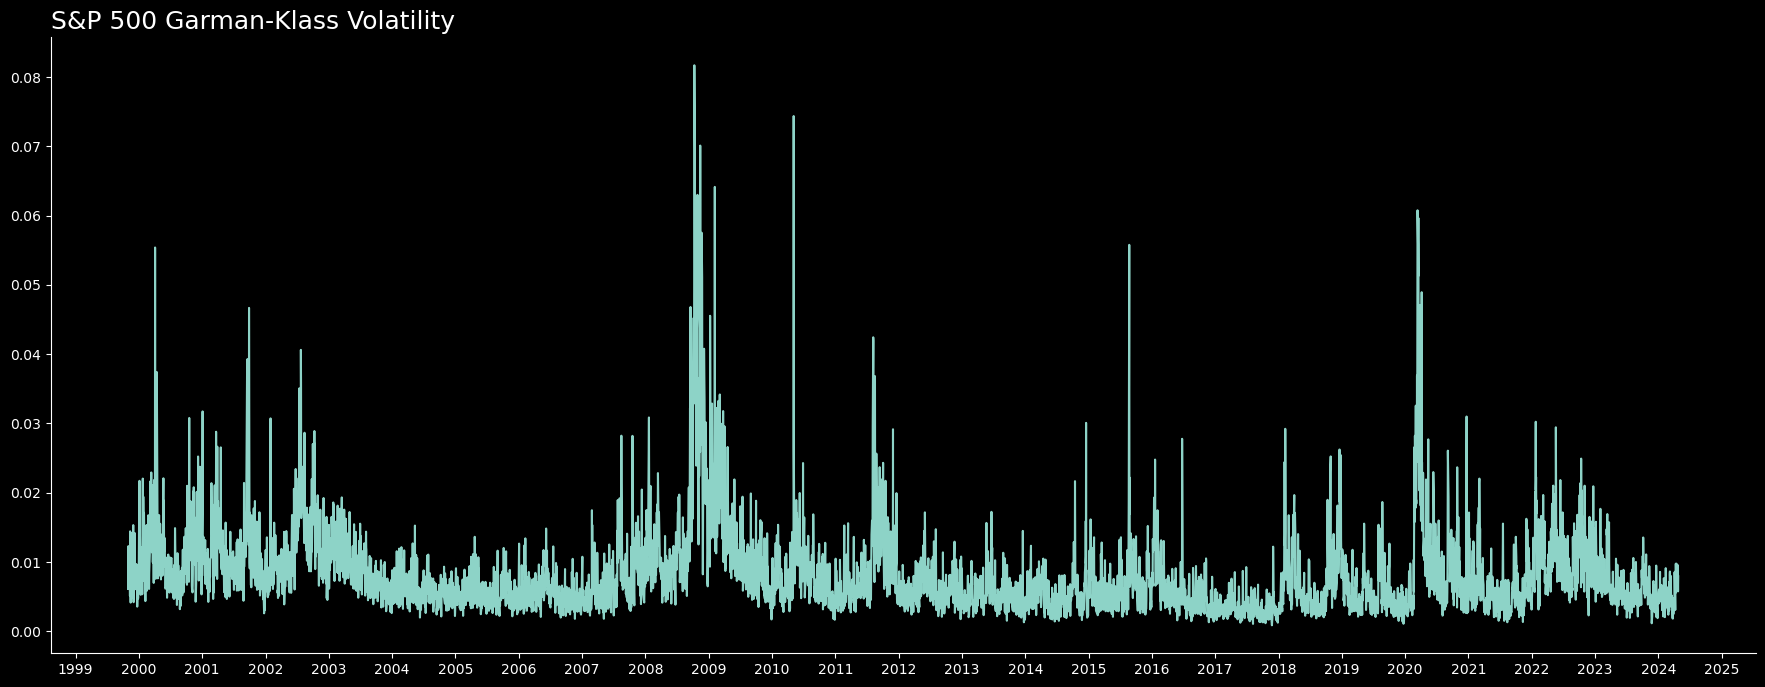

In [11]:
# Plot garman_klass volatility
plt.style.use('dark_background')
plt.figure(figsize=(22, 8))
plt.plot(df_spy.index, df_spy['gk_volatility'])

# Set the x-axis ticks to years
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Set title
plt.title('S&P 500 Garman-Klass Volatility',
          loc='left',
          fontsize=18
          )


sns.despine()
plt.show();

Key Events Behind Volatility Peaks

1. **2008-2009: Great Recession**  
   The global financial crisis caused extreme market instability due to the collapse of major financial institutions, a housing market crash, and high uncertainty.

2. **2010: Flash Crash**  
   On May 6, there was a sudden and severe drop in U.S. stock markets, followed by a rapid rebound. This event was attributed to high-frequency trading, algorithmic anomalies, and market imbalances.

3. **2011: Occupy Wall Street Movement**  
   From September 17 to November 15, a movement protesting economic inequality and corporate influence took place, highlighting public discontent with the financial system. This led to further uncertainty in financial markets.

4. **2015: Chinese Stock Market Turmoil**  
   In 2015, the Chinese stock market experienced significant volatility, with sharp swings and a steep decline. The turmoil in China, one of the world's largest economies, caused global market instability.

5. **2020: COVID-19 Pandemic**  
   The COVID-19 pandemic caused significant market disruption starting in early 2020. Lockdowns, supply chain interruptions, and widespread uncertainty led to unprecedented volatility. The rollout of vaccines and evolving public health responses continued to impact markets throughout 2020 and into 2021.

## The Relative Strength Index (RSI)

The Relative Strength Index (RSI) is a momentum oscillator used to measure the speed and change of price movements.  

It ranges from 0 to 100 and is commonly used in technical analysis to identify overbought and oversold conditions in a market or stock. 

RSI is calculated by comparing the average gains and losses over a specific period, typically 14 days. The formula for RSI is:

$$
\text{RSI} = 100 - \frac{100}{1 + \text{RS}}
$$

Where:

- **Relative Strength**: $ \text{RS} = \frac{\text{Average Gain}}{\text{Average Loss}}$
- **Average Gain**: The average of the gains over the period.
- **Average Loss**: The average of the losses over the same period.

Interpretation of Relative Strength Index (RSI):
* ***An RSI above 70 often indicates an overbought condition***, suggesting a potential reversal or correction, while an RSI ***below 30 indicates an oversold condition***, possibly signaling a rebound.  

We are using pandas_ta (Pandas Technical Analysis) library to calculate the RSI.

In [12]:
# Calculate the RSI of S&P 500
df_spy['rsi'] = ta.rsi(close=df_spy['close'], length=14)

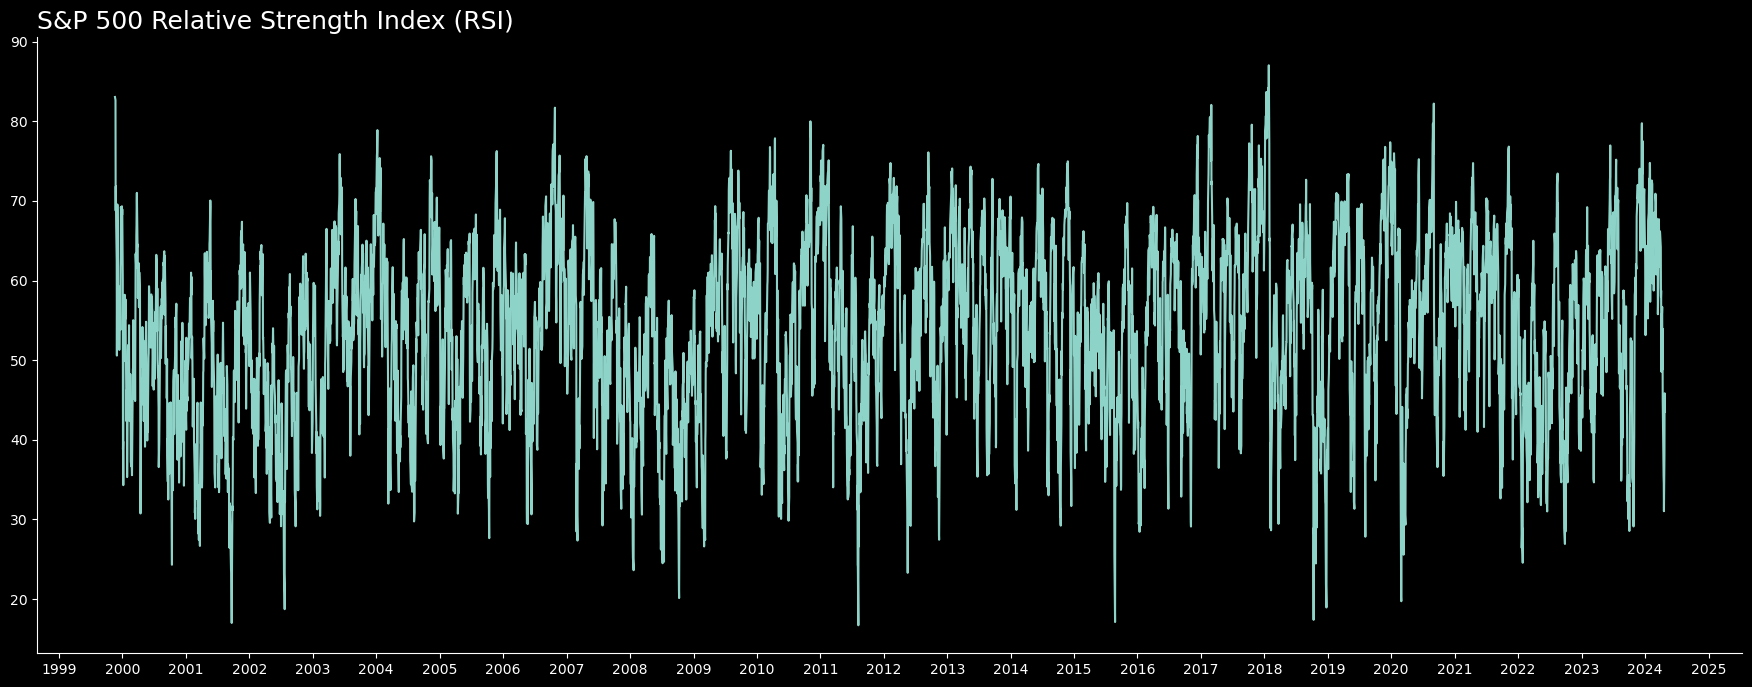

In [13]:
# Plot garman_klass volatility
plt.style.use('dark_background')
plt.figure(figsize=(22, 8))
plt.plot(df_spy.index, df_spy['rsi'])

# Set the x-axis ticks to years
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Set title
plt.title('S&P 500 Relative Strength Index (RSI)',
          loc='left',
          fontsize=18
          )


sns.despine()
plt.show();

## Bollinger Bands

Bollinger Bands are used to gauge volatility and identify potential overbought or oversold conditions.

Components of Bollinger Bands
* **Middle Band**: A simple moving average, typically a 20-period SMA.
* **Upper Band**: The middle band plus a multiple of the standard deviation (commonly 2 times the standard deviation).
* **Lower Band**: The middle band minus the same multiple of the standard deviation.

Interpretation of Bollinger Bands
* **Price Exceeding Bands**: If the price moves outside the bands, it may indicate that the asset is overbought (above the upper band) or oversold (below the lower band).
* **Band Expansion and Contraction**: Wider bands indicate higher volatility, while narrower bands indicate lower volatility.
* **Reversion to the Mean**: Prices tend to revert to the middle band after touching or exceeding the upper or lower bands. 

In [14]:
# Define the Bollinger Bands function
def bollinger_bands(data, length, std):
    # Sort the data index
    data.sort_index(ascending=True, inplace=True) 
    
    # Calculate BBands with a 20-period and 2 std
    bol_bands = ta.bbands(close=data['close'],
                                length=length,
                                std=std)

    # Names dict
    bb_names = {"BBL_20_2.0": "bb_low",
                "BBM_20_2.0": "bb_mid",
                "BBU_20_2.0": "bb_upper",
                "BBB_20_2.0": "bb_basis",
                "BBP_20_2.0": "bb_percentage"
                }

    # Rename cols
    bol_bands.rename(columns=bb_names, inplace=True)

    
    # Ensure that indices are alined before concatenation
    bol_bands.sort_index(ascending=True, inplace=True)
    bol_bands = bol_bands.reindex(data.index)

    # Concatenate Bollinger Bands with data
    data = pd.concat([data, bol_bands], axis= 1)


    return data

In [15]:
# Calculate the Bollinger Bands of S&P 500
df_spy = bollinger_bands(df_spy, 20, 2)

df_spy.tail()

,open,high,low,close,volume,gk_volatility,rsi,bb_low,bb_mid,bb_upper,bb_basis,bb_percentage
2024-04-19,499.44,500.455,493.8600,495.16,102212587,0.007705,31.028547,497.154167,514.1080,531.061833,6.595436,-0.058812
2024-04-22,497.83,502.380,495.4300,499.72,67961048,0.009565,38.081732,495.309801,513.0335,530.757199,6.909373,0.124415
2024-04-23,501.78,506.090,499.5328,505.65,64633620,0.007889,45.838505,494.608502,512.3275,530.046498,6.917059,0.311572
2024-04-24,506.56,507.370,503.1300,505.41,55928076,0.005763,45.589580,493.956283,511.6575,529.358717,6.919166,0.323529
2024-04-25,499.18,504.270,497.4900,503.49,69122368,0.007941,43.551970,493.460304,510.6735,527.886696,6.741371,0.291337


## Average True Range (ATR)

ATR measures the average range of price movements over a specified period, typically 14 days. It takes into account the following ranges for each period (day):

* **High-Low**: The range within the same trading session.
* **High-Close (Previous Day)**: If there's a gap between the previous close and the current high.
* **Low-Close (Previous Day)**: If there's a gap between the previous close and the current low.
ATR provides a more complete measure of volatility by considering both intraday price movements and gaps between trading sessions.


In [16]:
# Define the average true range function
def average_true_range(data, length):
    # Sort the data index
    data.sort_index(ascending=True, inplace=True)

    # Calculate the ATR with a 14-period moving average
    atr = ta.atr(high=data['high'],
                    low=data['low'],
                    close=data['close'],
                    length=length
                    )

    
    # Ensure that indices are alined before concatenation
    atr.sort_index(ascending=True, inplace=True)
    atr = atr.reindex(data.index)

    # Concatenate atr with data
    data = pd.concat([data, atr], axis=1)

    # Rename cols
    data.rename(columns={'ATRr_14': 'atr'}, inplace=True)

    return data

In [17]:
# Calculate the ATR of S&P 500
df_spy = average_true_range(df_spy, 14)

df_spy.tail()

,open,high,low,close,volume,gk_volatility,rsi,bb_low,bb_mid,bb_upper,bb_basis,bb_percentage,atr
2024-04-19,499.44,500.455,493.8600,495.16,102212587,0.007705,31.028547,497.154167,514.1080,531.061833,6.595436,-0.058812,5.872595
2024-04-22,497.83,502.380,495.4300,499.72,67961048,0.009565,38.081732,495.309801,513.0335,530.757199,6.909373,0.124415,5.968838
2024-04-23,501.78,506.090,499.5328,505.65,64633620,0.007889,45.838505,494.608502,512.3275,530.046498,6.917059,0.311572,6.010864
2024-04-24,506.56,507.370,503.1300,505.41,55928076,0.005763,45.589580,493.956283,511.6575,529.358717,6.919166,0.323529,5.884374
2024-04-25,499.18,504.270,497.4900,503.49,69122368,0.007941,43.551970,493.460304,510.6735,527.886696,6.741371,0.291337,6.029776


## Moving Average Convergence Divergence (MACD)

the difference between two exponential moving averages (EMAs) and is accompanied by a signal line (another EMA) and a histogram.  

It consists of three key components:
* **MACD Line**: The difference between a fast EMA (typically 12-period) and a slow EMA (typically 26-period). This line is used to measure momentum.
* **Signal Line**: A 9-period EMA of the MACD line. This serves as a smoothing mechanism to generate buy and sell signals.
* **Histogram**: The difference between the MACD line and the signal line. The histogram indicates the strength of momentum and whether it's increasing or decreasing.

In [18]:
# Define MACD function
def moving_average_cd(data):
    # Sort the data index
    data.sort_index(ascending=True, inplace=True)

    # Calculate MACD
    macd = data.ta.macd(close=data['close'])

    # Names Dict
    macd_names = {"MACD_12_26_9": "macd",
                  "MACDh_12_26_9": "macd_hist",
                  "MACDs_12_26_9": "macd_signal"
                  }
    # Rename Columns
    macd.rename(columns=macd_names, inplace=True)

    # Ensure that the indices are alined
    macd.sort_index(ascending=True, inplace=True)
    macd = macd.reindex(data.index)

    # Concatenate macd with data
    data = pd.concat([data, macd], axis=1)

    return data

In [19]:
# Calculate the MACD of S&P 500
df_spy = moving_average_cd(df_spy)
df_spy.tail()

,open,high,low,close,volume,gk_volatility,rsi,bb_low,bb_mid,bb_upper,bb_basis,bb_percentage,atr,macd,macd_hist,macd_signal
2024-04-19,499.44,500.455,493.8600,495.16,102212587,0.007705,31.028547,497.154167,514.1080,531.061833,6.595436,-0.058812,5.872595,-3.161249,-3.054157,-0.107092
2024-04-22,497.83,502.380,495.4300,499.72,67961048,0.009565,38.081732,495.309801,513.0335,530.757199,6.909373,0.124415,5.968838,-3.523914,-2.733458,-0.790456
2024-04-23,501.78,506.090,499.5328,505.65,64633620,0.007889,45.838505,494.608502,512.3275,530.046498,6.917059,0.311572,6.010864,-3.294846,-2.003512,-1.291334
2024-04-24,506.56,507.370,503.1300,505.41,55928076,0.005763,45.589580,493.956283,511.6575,529.358717,6.919166,0.323529,5.884374,-3.096974,-1.444512,-1.652462
2024-04-25,499.18,504.270,497.4900,503.49,69122368,0.007941,43.551970,493.460304,510.6735,527.886696,6.741371,0.291337,6.029776,-3.059815,-1.125882,-1.933933


## Dollar Volume

Dollar volume represents the total monetary value of all trades for a specific security or asset within a given period. It is calculated by multiplying the price (often the closing price) by the trading volume.

In [20]:
# Calculate the dollar volume of S&P 500
df_spy['dollar_volume_millions'] = (df_spy['close'] * df_spy['volume']) / 1e6

df_spy.tail()

,open,high,low,close,volume,gk_volatility,rsi,bb_low,bb_mid,bb_upper,bb_basis,bb_percentage,atr,macd,macd_hist,macd_signal,dollar_volume_millions
2024-04-19,499.44,500.455,493.8600,495.16,102212587,0.007705,31.028547,497.154167,514.1080,531.061833,6.595436,-0.058812,5.872595,-3.161249,-3.054157,-0.107092,50611.584579
2024-04-22,497.83,502.380,495.4300,499.72,67961048,0.009565,38.081732,495.309801,513.0335,530.757199,6.909373,0.124415,5.968838,-3.523914,-2.733458,-0.790456,33961.494907
2024-04-23,501.78,506.090,499.5328,505.65,64633620,0.007889,45.838505,494.608502,512.3275,530.046498,6.917059,0.311572,6.010864,-3.294846,-2.003512,-1.291334,32681.989953
2024-04-24,506.56,507.370,503.1300,505.41,55928076,0.005763,45.589580,493.956283,511.6575,529.358717,6.919166,0.323529,5.884374,-3.096974,-1.444512,-1.652462,28266.608891
2024-04-25,499.18,504.270,497.4900,503.49,69122368,0.007941,43.551970,493.460304,510.6735,527.886696,6.741371,0.291337,6.029776,-3.059815,-1.125882,-1.933933,34802.421064


## Price Direction

A binary variable where 1 is higher than the previous day. This is going to be our target variable.

In [21]:
# Add price direction binary column; 1 = close price higher than yesterday
df_spy['price_direction'] = (df_spy['close'].shift(1) < df_spy['close']).astype(int)

df_spy[['close', 'price_direction']]

,close,price_direction
1999-11-01,135.5625,0
1999-11-02,134.5937,0
1999-11-03,135.5000,1
1999-11-04,136.5312,1
1999-11-05,137.8750,1
...,...,...
2024-04-19,495.1600,0
2024-04-22,499.7200,1
2024-04-23,505.6500,1
2024-04-24,505.4100,0
